In [33]:
#|default_exp app

Find the working app here in a hugging face space: https://huggingface.co/spaces/Jhangir/plastic_vs_aluminum/tree/main
Creates, tests, and exports code of model classifying images as aluminum or plastic.

install necessary packages on Kaggle.com. creates search function using duckduckgo.

In [5]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search gradio
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ypy-websocket 0.8.2 requires aiofiles<23,>=22.1.0, but you have aiofiles 23.2.1 which is incompatible.


Define classifier, is_plastic.

In [6]:
#|export
from fastai.vision.all import *
import gradio as gr

def is_plastic(x): return x[0].isupper()

Test search to find desired types of images. plastic/aluminum can/trash/bottle photos work fine. There are plenty more types of photos we could use like cups, but this is fine for now.

Searching for 'plastic can photos'


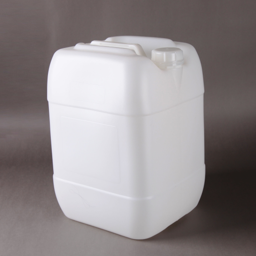

In [22]:
from fastdownload import download_url
from fastai.vision.all import *
download_url(search_images('plastic can photos', max_images=1)[0], 'plastic.jpg', show_progress=False)
Image.open('plastic.jpg').to_thumb(256,256)

Download Dataset

In [9]:
searches = 'plastic','aluminum'
path = Path('plastic_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} trash photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} can photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} bottle photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'plastic trash photo'
Searching for 'plastic can photo'
Searching for 'plastic bottle photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Searching for 'aluminum trash photo'
Searching for 'aluminum can photo'
Searching for 'aluminum bottle photo'


Filter out images that do not work correctly

In [10]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

Create Dataloader with image and category blocks.

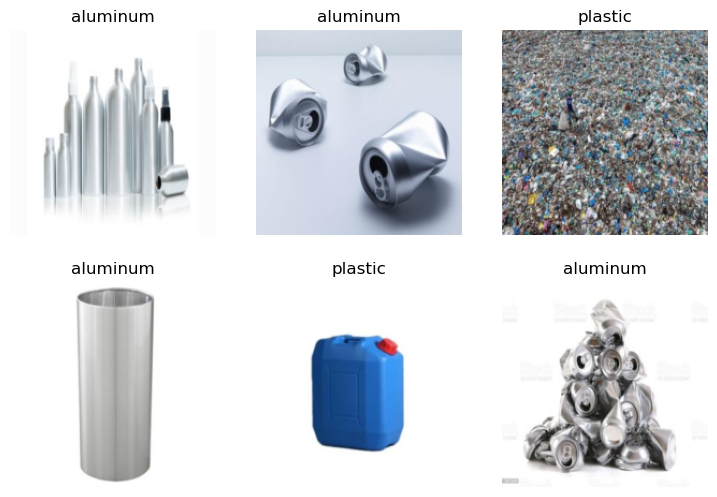

In [11]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Use transfer learning based on the resnet18 model and then fine tune for 5 epochs.

In [12]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s] 


epoch,train_loss,valid_loss,error_rate,time
0,1.206433,1.501993,0.454545,00:06


epoch,train_loss,valid_loss,error_rate,time
0,0.455333,0.748938,0.333333,00:02
1,0.322880,0.368547,0.151515,00:01
2,0.239019,0.246004,0.060606,00:01
3,0.191483,0.222447,0.060606,00:01


Test against previously downloaded image.

In [23]:
is_plastic,_,probs = learn.predict(PILImage.create('plastic.jpg'))
print(f"This is a: {is_plastic}.")
print(f"Probability it's plastic: {probs[1]:.4f}")

This is a: plastic.
Probability it's plastic: 0.9872


Export model to be used in the future (in the huggingface space).

In [24]:
learn.export('PvsAmodel.pkl')

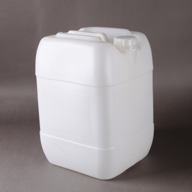

In [25]:
im = PILImage.create('plastic.jpg')
im.thumbnail((192,192))
im

In [ ]:
#|export
learn = load_learner('PvsAmodel.pkl')

Use the model to predict if image is plastic.

In [26]:
learn.predict(im)

('plastic', tensor(1), tensor([0.0160, 0.9840]))

Have a more readable prediction.

In [29]:
#|export
categories = ('aluminum', 'plastic')

def classify_image(img):
    pred,idx,probs = learn.predict(img)
    return dict(zip(categories, map(float,probs)))

In [30]:
classify_image(im)

{'aluminum': 0.015960799530148506, 'plastic': 0.9840391278266907}

Download some sample images. Plastic cup ran with a 83% confidence that it was aluminum.

In [31]:
download_url(search_images('plastic trash photos', max_images=1)[0], 'plastic1.jpg', show_progress=False)
download_url(search_images('aluminum trash photos', max_images=1)[0], 'aluminum1.jpg', show_progress=False)
download_url(search_images('plastic cup photos', max_images=1)[0], 'plasticcup1.jpg', show_progress=False)

Searching for 'plastic trash photos'


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Searching for 'aluminum trash photos'
Searching for 'plastic cup photos'


Path('plasticcup1.jpg')

export some cells into a app.py file

In [ ]:
from nbdev.export import notebook2script
notebook2script('app.ipynb')